In [4]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("yuriykatser/industrial-data-from-the-arc-furnace")

dataframes = {}

for archivo in archivos_esperados:
    full_path = os.path.join(path, archivo)
    
    try:
        # Cargamos el csv
        df = pd.read_csv(full_path)
        dataframes[archivo] = df # Guardamos una referencia por si quieres usarla luego
        
        print(f"📂 ARCHIVO: {archivo}")
        print(f"   Dimensiones: {df.shape} (Filas, Columnas)")
        print(f"   Columnas: {list(df.columns)}")
        
        # Si tiene 'HEATID', verificamos cuántas coladas únicas hay para ver la granularidad
        if 'HEATID' in df.columns:
            unique_heats = df['HEATID'].nunique()
            print(f"   Coladas únicas (HEATID): {unique_heats}")
        else:
            print("   ⚠️ No contiene columna 'HEATID'")
            
        print("-" * 60)

    except FileNotFoundError:
        print(f"❌ ERROR: No se encontró el archivo {archivo} en la ruta especificada.")
    except Exception as e:
        print(f"❌ ERROR al leer {archivo}: {e}")

📂 ARCHIVO: eaf_transformer.csv
   Dimensiones: (271712, 5) (Filas, Columnas)
   Columnas: ['TAP', 'HEATID', 'STARTTIME', 'DURATION', 'MW']
   Coladas únicas (HEATID): 20813
------------------------------------------------------------
📂 ARCHIVO: basket_charged.csv
   Dimensiones: (137685, 5) (Filas, Columnas)
   Columnas: ['MAT_CODE', 'MAT_DEC', 'HEATID', 'DATETIME', 'CHARGED_AMOUNT']
   Coladas únicas (HEATID): 20806
------------------------------------------------------------
📂 ARCHIVO: eaf_temp.csv
   Dimensiones: (85104, 4) (Filas, Columnas)
   Columnas: ['HEATID', 'DATETIME', 'TEMP', 'VALO2_PPM']
   Coladas únicas (HEATID): 20827
------------------------------------------------------------
📂 ARCHIVO: eaf_final_chemical_measurements.csv
   Dimensiones: (3709, 15) (Filas, Columnas)
   Columnas: ['HEATID', 'POSITIONROW', 'DATETIME', 'VALC', 'VALSI', 'VALMN', 'VALP', 'VALS', 'VALCU', 'VALCR', 'VALMO', 'VALNI', 'VALAS', 'VALSN', 'VALN']
   Coladas únicas (HEATID): 3709
-----------------

C:\Users\js834\AppData\Local\Temp\ipykernel_16512\3568921112.py:13: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path)


📂 ARCHIVO: eaf_added_materials.csv
   Dimensiones: (79944, 5) (Filas, Columnas)
   Columnas: ['MAT_CODE', 'MAT_DEC', 'HEATID', 'DATETIME', 'CHARGE_AMOUNT']
   Coladas únicas (HEATID): 20506
------------------------------------------------------------
📂 ARCHIVO: inj_mat.csv
   Dimensiones: (4011646, 4) (Filas, Columnas)
   Columnas: ['REVTIME', 'INJ_AMOUNT_CARBON', 'INJ_FLOW_CARBON', 'HEATID']
   Coladas únicas (HEATID): 20827
------------------------------------------------------------
📂 ARCHIVO: eaf_gaslance_mat.csv
   Dimensiones: (5748194, 6) (Filas, Columnas)
   Columnas: ['REVTIME', 'O2_AMOUNT', 'GAS_AMOUNT', 'O2_FLOW', 'GAS_FLOW', 'HEATID']
   Coladas únicas (HEATID): 20827
------------------------------------------------------------
📂 ARCHIVO: lf_initial_chemical_measurements.csv
   Dimensiones: (20827, 12) (Filas, Columnas)
   Columnas: ['HEATID', 'POSITIONROW', 'DATETIME', 'VALC', 'VALSI', 'VALMN', 'VALP', 'VALS', 'VALCU', 'VALCR', 'VALMO', 'VALNI']
   Coladas únicas (HEATID):

In [ ]:
import pandas as pd
import os

# --- 1. CONFIGURACIÓN Y CARGA ---
def load_standardized(filename):
    path_file = os.path.join(path, filename)
    # Low_memory=False ayuda a que pandas infiera mejor los tipos en archivos grandes
    df = pd.read_csv(path_file, low_memory=False) 
    df.columns = df.columns.str.lower().str.strip() 
    return df

print("Cargando, estandarizando y LIMPIANDO TIPOS...")

# Carga de archivos
df_gas = load_standardized("eaf_gaslance_mat.csv")
df_inj = load_standardized("inj_mat.csv")
df_ladle = load_standardized("ladle_tapping.csv")
df_chem_initial = load_standardized("lf_initial_chemical_measurements.csv")
# df_target = load_standardized("eaf_temp.csv") 

# --- PASO CRÍTICO: LIMPIEZA DE TIPOS DE DATOS ---
# Convertimos a numérico forzoso. Si hay basura, se convierte en NaN.

# Limpieza para Gases
cols_gas = ['o2_amount', 'gas_amount']
for col in cols_gas:
    df_gas[col] = pd.to_numeric(df_gas[col], errors='coerce')

# Limpieza para Inyecciones
df_inj['inj_amount_carbon'] = pd.to_numeric(df_inj['inj_amount_carbon'], errors='coerce')

# Limpieza para Ladle (Materiales)
df_ladle['charge_amount'] = pd.to_numeric(df_ladle['charge_amount'], errors='coerce')

print("✅ Tipos de datos corregidos. Iniciando agregación...")

# --- 2. AGREGACIÓN DE SERIES TEMPORALES ---
print("Agregando series temporales...")

# A. Gases
grp_gas = df_gas.groupby('heatid').agg({
    'o2_amount': 'max',   
    'gas_amount': 'max'   
}).rename(columns={'o2_amount': 'total_o2_lance', 'gas_amount': 'total_gas_lance'})

# B. Inyecciones
grp_inj = df_inj.groupby('heatid').agg({
    'inj_amount_carbon': 'max' 
}).rename(columns={'inj_amount_carbon': 'total_injected_carbon'})

# --- 3. PIVOTADO DE MATERIALES ---
print("Pivotando materiales añadidos...")

top_materials = df_ladle['mat_code'].value_counts().head(10).index 
df_ladle_filtered = df_ladle[df_ladle['mat_code'].isin(top_materials)]

pivot_ladle = df_ladle_filtered.pivot_table(
    index='heatid', 
    columns='mat_code', 
    values='charge_amount', 
    aggfunc='sum',
    fill_value=0 
).add_prefix('added_mat_')

# --- 4. FUSIÓN FINAL ---
print("Fusionando en el Dataset Maestro...")

df_master = df_chem_initial.copy() 

# Merges (Left joins)
df_master = df_master.merge(grp_gas, on='heatid', how='left')
df_master = df_master.merge(grp_inj, on='heatid', how='left')
df_master = df_master.merge(pivot_ladle, on='heatid', how='left')

# Rellenar nulos técnicos generados por el merge
cols_to_fix = ['total_o2_lance', 'total_gas_lance', 'total_injected_carbon']
# Usamos fillna(0) porque si no hay registro en la tabla de gas, asumimos consumo 0
df_master[cols_to_fix] = df_master[cols_to_fix].fillna(0)

print(f"✅ Dataset Maestro creado correctamente.")
print(f"Dimensiones finales: {df_master.shape}")
df_master.head()

Cargando, estandarizando y LIMPIANDO TIPOS...
✅ Tipos de datos corregidos. Iniciando agregación...
Agregando series temporales...
Pivotando materiales añadidos...
Fusionando en el Dataset Maestro...
✅ Dataset Maestro creado correctamente.
Dimensiones finales: (20827, 25)


,heatid,positionrow,datetime,valc,valsi,valmn,valp,vals,valcu,valcr,...,added_mat_140107,added_mat_202007,added_mat_202008,added_mat_202039,added_mat_202063,added_mat_203068,added_mat_203085,added_mat_205069,added_mat_360258,added_mat_705043
0,6F0020,1,2016-01-01 19:59:00,"0,2312","0,2449","1,2652","0,0076","0,0147","0,2072","0,0726",...,0.0,2067.0,0.0,0.0,0.0,237.0,40.0,100.0,414.0,0.0
1,6F0021,1,2016-01-01 20:59:00,"0,2507","0,2687","1,2916","0,0055","0,0204","0,2045","0,0747",...,0.0,2065.0,0.0,0.0,0.0,238.0,50.0,75.0,2912.0,0.0
2,6F0022,1,2016-01-01 21:53:00,"0,234","0,2276","1,1963","0,0056","0,0193","0,1898","0,0695",...,0.0,2066.0,0.0,0.0,0.0,236.0,50.0,75.0,416.0,0.0
3,6F0023,1,2016-01-01 23:27:00,"0,3652","0,2154","0,7934","0,0078","0,025","0,2154","0,0956",...,0.0,1267.0,0.0,0.0,156.0,419.0,50.0,75.0,412.0,0.0
4,6F0024,1,2016-01-02 00:32:00,"0,374","0,1932","0,7948","0,0071","0,0202","0,2191","0,1029",...,0.0,1270.0,0.0,0.0,155.0,418.0,50.0,75.0,413.0,0.0


In [10]:
import pandas as pd

# 1. Cargar eaf_temp
print("Inspeccionando archivo de temperaturas...")
df_temp = load_standardized("eaf_temp.csv")

print(f"Columnas encontradas en eaf_temp: {list(df_temp.columns)}")

# 2. DETECCIÓN AUTOMÁTICA DE COLUMNAS
# Buscamos columna que tenga "temp" (pero que no sea 'timestamp')
cols_temp = [c for c in df_temp.columns if 'temp' in c and 'time' not in c]
# Buscamos columna de tiempo (time, date, datetime)
cols_time = [c for c in df_temp.columns if 'time' in c or 'date' in c]

col_temp_name = cols_temp[0] if cols_temp else None
col_time_name = cols_time[0] if cols_time else None

if col_temp_name and col_time_name:
    print(f"✅ Columna Temperatura detectada: '{col_temp_name}'")
    print(f"✅ Columna Tiempo detectada: '{col_time_name}'")
    
    # 3. LIMPIEZA Y FILTRADO
    # Convertir a numérico y fecha
    df_temp[col_temp_name] = pd.to_numeric(df_temp[col_temp_name], errors='coerce')
    df_temp[col_time_name] = pd.to_datetime(df_temp[col_time_name], errors='coerce')
    
    # Ordenar por tiempo para obtener la ÚLTIMA medición (la del vaciado)
    # Groupby heatid -> Last
    df_target = df_temp.sort_values(col_time_name).groupby('heatid').tail(1)
    
    # Seleccionar solo ID y Temperatura, y renombrar para el merge
    df_target = df_target[['heatid', col_temp_name]].rename(columns={col_temp_name: 'target_temperature'})
    
    # 4. MERGE CON EL MAESTRO (Inputs)
    # Verificamos que df_master exista (de los pasos anteriores)
    if 'df_master' in locals():
        print("Fusionando Inputs con Target...")
        
        # Limpieza preventiva de duplicados si re-ejecutas
        if 'target_temperature' in df_master.columns:
            df_master = df_master.drop(columns=['target_temperature'])
            
        # Inner Join: Solo queremos coladas que tengan DATOS y RESULTADO
        df_final = df_master.merge(df_target, on='heatid', how='inner')
        
        # Limpieza final de columnas técnicas
        cols_drop = ['datetime', 'positionrow', 'filter_key_date', 'measure_time', col_time_name]
        df_final = df_final.drop(columns=[c for c in cols_drop if c in df_final.columns])
        
        # Eliminar nulos en el target
        df_final = df_final.dropna(subset=['target_temperature'])
        # Rellenar nulos en inputs con 0
        df_final = df_final.fillna(0)
        
        print("-" * 40)
        print(f"🎉 ¡ÉXITO! DATASET MAESTRO COMPLETADO")
        print(f"Dimensiones finales: {df_final.shape}")
        
        # 5. GUARDAR EL TESORO
        nombre_fichero = "dataset_final_acero.csv"
        df_final.to_csv(nombre_fichero, index=False)
        print(f"💾 Archivo guardado como: {nombre_fichero}")
        print("Usa este archivo para Streamlit y el modelado.")
        
        display(df_final.head())
        
    else:
        print("❌ ERROR: No encuentro 'df_master' en memoria. Debes ejecutar los pasos anteriores de Inputs primero.")

else:
    print("❌ ERROR: No pude identificar automáticamente las columnas de temperatura o tiempo.")
    print("Por favor, revisa la lista de columnas impresa arriba.")

Inspeccionando archivo de temperaturas...
Columnas encontradas en eaf_temp: ['heatid', 'datetime', 'temp', 'valo2_ppm']
✅ Columna Temperatura detectada: 'temp'
✅ Columna Tiempo detectada: 'datetime'
Fusionando Inputs con Target...
----------------------------------------
🎉 ¡ÉXITO! DATASET MAESTRO COMPLETADO
Dimensiones finales: (20827, 27)
💾 Archivo guardado como: dataset_final_acero.csv
Usa este archivo para Streamlit y el modelado.


,heatid,valc,valsi,valmn,valp,vals,valcu,valcr,valmo,valni,...,added_mat_202063,added_mat_203068,added_mat_203085,added_mat_205069,added_mat_360258,added_mat_705043,power_active_mean,power_active_max,total_power_on_time,target_temperature
0,6F0020,0.2312,0.2449,1.2652,0.0076,0.0147,0.2072,0.0726,0.0194,0.1323,...,0.0,237.0,40.0,100.0,414.0,0.0,9.0,16.0,0.0,1650.0
1,6F0021,0.2507,0.2687,1.2916,0.0055,0.0204,0.2045,0.0747,0.0206,0.1326,...,0.0,238.0,50.0,75.0,2912.0,0.0,0.0,0.0,0.0,1649.0
2,6F0022,0.2340,0.2276,1.1963,0.0056,0.0193,0.1898,0.0695,0.0203,0.1218,...,0.0,236.0,50.0,75.0,416.0,0.0,0.0,0.0,0.0,1636.0
3,6F0023,0.3652,0.2154,0.7934,0.0078,0.0250,0.2154,0.0956,0.0342,0.2051,...,156.0,419.0,50.0,75.0,412.0,0.0,0.0,0.0,0.0,1665.0
4,6F0024,0.3740,0.1932,0.7948,0.0071,0.0202,0.2191,0.1029,0.0267,0.1534,...,155.0,418.0,50.0,75.0,413.0,0.0,2.5,5.0,0.0,1633.0


Filas originales: 20827
Filas tras limpieza de energía cero: 14323
Entrenando modelo...
------------------------------
📊 RESULTADOS DEL MODELO:
   RMSE (Error medio): 12.96 °C
   R2 (Explicabilidad): 0.1212
------------------------------


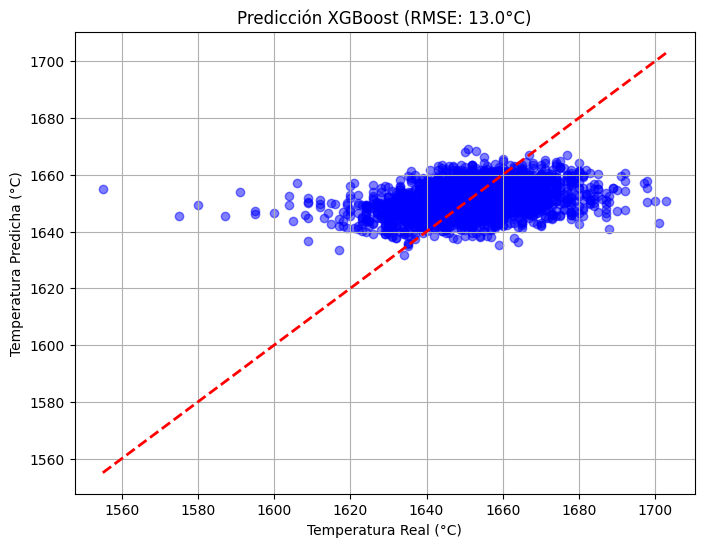

Guardando modelo en BentoML Store...
✅ Modelo guardado como 'eaf_temperature_model'. Listo para usar en service.py


In [12]:
import pandas as pd
import numpy as np
import xgboost as xgb
import bentoml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. CARGA Y FILTRADO DE CALIDAD
df = pd.read_csv("dataset_final_acero.csv")

print(f"Filas originales: {len(df)}")
# Eliminamos coladas donde la energía sea 0 (datos erróneos de fusión)
df_clean = df[df['power_active_mean'] > 0.1].copy()
print(f"Filas tras limpieza de energía cero: {len(df_clean)}")

# 2. SEPARAR X (Inputs) e y (Target)
# Quitamos el ID (no aporta química) y el Target de la X
X = df_clean.drop(columns=['heatid', 'target_temperature'])
y = df_clean['target_temperature']

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. ENTRENAMIENTO (XGBoost Regressor)
# Usamos parámetros estándar robustos para industria
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    n_jobs=-1
)

print("Entrenando modelo...")
model.fit(X_train, y_train)

# 4. EVALUACIÓN
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("-" * 30)
print(f"📊 RESULTADOS DEL MODELO:")
print(f"   RMSE (Error medio): {rmse:.2f} °C")
print(f"   R2 (Explicabilidad): {r2:.4f}")
print("-" * 30)

# Gráfico Real vs Predicho (Obligatorio para la memoria)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, preds, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Línea ideal
plt.xlabel("Temperatura Real (°C)")
plt.ylabel("Temperatura Predicha (°C)")
plt.title(f"Predicción XGBoost (RMSE: {rmse:.1f}°C)")
plt.grid(True)
plt.show()

# 5. GUARDAR MODELO CON BENTOML
# Esto crea el paquete que usará tu App de Streamlit
print("Guardando modelo en BentoML Store...")
bentoml.xgboost.save_model("eaf_temperature_model", model)
print("✅ Modelo guardado como 'eaf_temperature_model'. Listo para usar en service.py")

🔝 TOP 10 VARIABLES MÁS INFLUYENTES:
             feature  importance
12  added_mat_140107    0.266867
21  added_mat_705043    0.061560
20  added_mat_360258    0.060562
6              valcr    0.060418
15  added_mat_202039    0.053741
3               valp    0.039627
17  added_mat_203068    0.038370
2              valmn    0.037334
14  added_mat_202008    0.034177
7              valmo    0.033657


C:\Users\js834\AppData\Local\Temp\ipykernel_16512\2636009223.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')


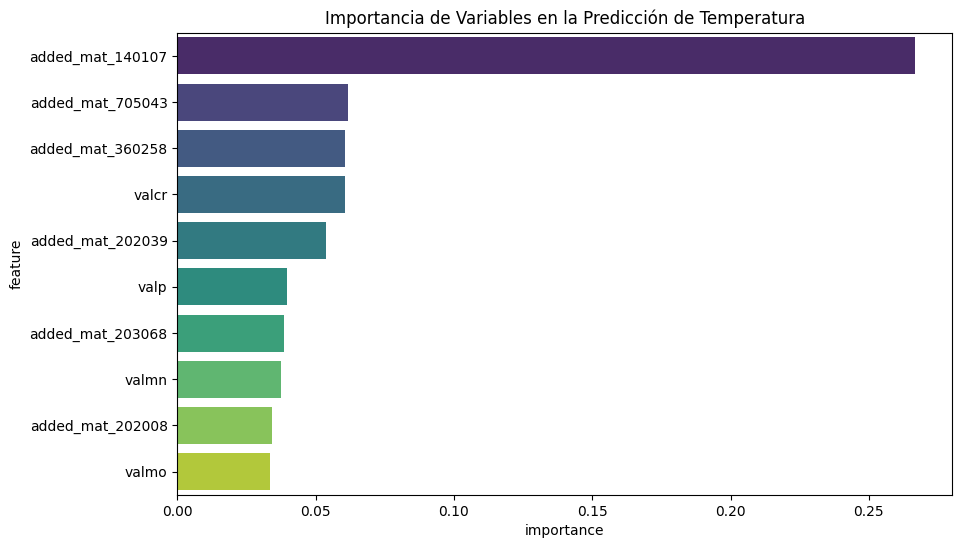

In [13]:
# Ver qué variables usa más el modelo
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("🔝 TOP 10 VARIABLES MÁS INFLUYENTES:")
print(feature_importance)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title("Importancia de Variables en la Predicción de Temperatura")
plt.show()